In [ ]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

In [1]:
# LDDMM landmark dynamics - Corpora Callosa
%cd ..
from src.manifolds.landmarks import *
M = landmarks(3)
print(M)

/home/line/Dropbox/theanogeometry
3 landmarks in R^2 (dim 6). kernel Gaussian, k_alpha=1, k_sigma=[[ 0.5  0. ]
 [ 0.   0.5]]


In [2]:
# Riemannian structure
from src.Riemannian import metric
truncate_high_order_derivatives = True
metric.initialize(M)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [3]:
from src.plotting import *
%matplotlib inline
plt.rcParams['figure.figsize'] = 7, 7

In [20]:
from src.statistics.Regression.params import *

# initialize
M.N.set_value(20)
n_steps.set_value(100)

n_samples.set_value(20)
mx.set_value(1)

# Obs: takes time to load
from src.framebundle import FM
from src.stochastics import stochastic_development
FM.initialize(M)
stochastic_development.initialize(M)

from src.statistics.Regression import Processes
Processes.initialize(M)

from src.statistics.Regression import hfunction
hfunction.initialize(M)

from src.statistics.Regression import LaplaceApprox
LaplaceApprox.initialize(M)

from scipy import io
A=io.loadmat('/home/line/Desktop/Regressiongpu/Regression/ipmi-data/matlab.mat')

1
1
1
1


# Corpus Callosum data:

In [21]:
Seq = lambda m, n: [i*n//m + n//(2*m) for i in range(m)]

In [22]:
# load data
data=io.loadmat('/home/line/Desktop/Regressiongpu/Regression/ipmi-data/dataM-corpora-callosa-ipmi-full.mat')
vi = data['vi'] # corpora callosa
Nobs = vi.shape[1]
N0 = int(vi.shape[0]/2-1)
qs = vi[0:-2,:].T.reshape((Nobs,N0,2))

yObsM = qs[0:n_samples.get_value(),Seq(M.N.get_value(),N0),:]/20
yObs = yObsM.reshape((n_samples.get_value(),M.dim.eval()))
print(yObs.shape)

(20, 40)


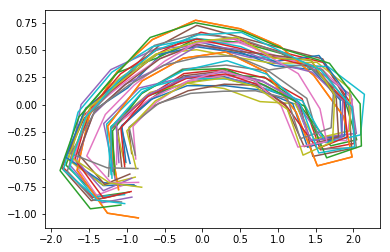

In [23]:
%matplotlib inline
for i in range(n_samples.get_value()):
    plt.plot(yObsM[i,:,0],yObsM[i,:,1])

In [24]:
gen = np.empty((n_samples.get_value()), dtype = str)
ald = np.zeros(n_samples.get_value())
for i in range(n_samples.get_value()):
    ald[i] = A['combined'][0,i][2][0]
    gen[i] = A['combined'][0,i][1][0][0]

xT0 = ald.reshape((n_samples.get_value(),mx.get_value()))

In [25]:
ui0 = np.linalg.lstsq(xT0, yObs)[0].flatten()
ui0 = ui0/np.linalg.norm(ui0)

x01 = np.zeros(mx.get_value())

In [26]:
W0 = np.array([[np.linalg.norm(ui0)]])[0:mx.get_value(),0:mx.get_value()]
drift0 = np.array([0.01,0.01])[0:mx.get_value()]

tau0 = 0.1

y0 = np.mean(yObs, axis = 0)

para0 = np.hstack((tau0,drift0,W0.flatten(),y0.flatten(),ui0.flatten()))
print("Initial para = ", para0)

Initial para =  [ 0.1         0.01        1.         -0.95051616 -0.79643621 -1.34308947
 -0.8200915  -1.74755248 -0.53523925 -1.51694971 -0.07390994 -1.08094977
  0.2314882  -0.60067508  0.47846696 -0.06510727  0.6080723   0.49182292
  0.55872467  1.00831914  0.43836512  1.51294564  0.34439381  1.89893364
  0.02828033  1.92696864 -0.33266853  1.48387396 -0.39977664  1.22770941
  0.01204689  0.7866895   0.20090036  0.30005123  0.2857981  -0.22507065
  0.24971705 -0.72819195  0.08356089 -1.13812837 -0.2033343  -1.07342373
 -0.59345329 -0.16853547 -0.14106425 -0.23817323 -0.14652462 -0.30933893
 -0.09553435 -0.2692278  -0.01344129 -0.19222876  0.0413108  -0.10642505
  0.08424111 -0.01145916  0.10816975  0.08744587  0.09859693  0.17912658
  0.07767538  0.26837332  0.06014463  0.33762649  0.00451862  0.34281113
 -0.05906559  0.26463255 -0.07017275  0.21868255  0.00256751  0.13995327
  0.03556154  0.05326505  0.05116778 -0.0403052   0.04509819 -0.13007376
  0.01589861 -0.20404478 -0.0353099

# Laplace Approximation:

### Optimal processes:

In [27]:
dwtv = np.random.normal(0.0, dt.eval(), (n_samples.get_value(),n_steps.get_value(),mx.get_value()))

start = time.time()
print(M.hf(dwtv.flatten(),yObs,xT0,x01,para0))
diff = time.time() - start
print("time h = ", diff)

start = time.time()
print(M.logdethesshf(dwtv.flatten(),yObs,xT0,x01,para0))
diff = time.time() - start
print("time = ", diff)

1.467353965001985e+34
time h =  319.64765882492065
-118398.19836732945
time =  2473.2121436595917


In [25]:
start = time.time()
dWtop = multprocdwt(para0,x01,yObs,xT0,n_pool=1)
diff = time.time() - start
print("time = ", diff)

Start likelihood =  -71726.80338449344
like =  -31534864.977120627
like =  -5743635360173177.0
like =  -3.3905057775685793e+40
like =  -6.947649585992374e+114
sucessfully terminated
Start likelihood =  -201012.56321815253
like =  -971920354.6904386
like =  -1.649977766797837e+20
like =  -8.037814256865166e+53
like =  -5.116756298923518e+105
sucessfully terminated
Start likelihood =  -240145.44805962313
like =  -1690978356.584373
like =  -8.68200505382249e+20
like =  -1.1710186059422373e+56
like =  -4.283202643639373e+84
sucessfully terminated
Start likelihood =  -216613.9419746836
like =  -1214414711.2119868
like =  -3.2175946332468353e+20
like =  -5.9607052603846864e+54
like =  -2.8163015246991052e+82
sucessfully terminated
Start likelihood =  -113400.36074895722
like =  -150929651.1529597
like =  -6.216022523135058e+17
like =  -4.2977530227024627e+46
like =  -1.4845615214055329e+133
sucessfully terminated
Start likelihood =  -154270.75716338528
like =  -408502525.9686277
like =  -1.2

In [23]:
def multprocdwt(para,x0,y,xT,n_pool):
    
    dwt = np.zeros((y.shape[0],n_steps.get_value()))
    for i in range(y.shape[0]):
        dwt[i,:] = M.multprocdwti(para,x0,(y[i,:],xT[i,:]))
    #p = Pool(processes = n_pool)
    #sol = p.map(partial(M.multprocdwti,para,x0),\
    #                     mpu.inputArgs(y,xT),chunksize = n_samples.get_value()/n_pool)
    #res = list(sol)
    #p.terminate()
    
    return dwt#np.array(zip(res))

### Estimation:

In [16]:
dwtv = np.random.normal(0.0, dt.eval(), (n_samples.get_value(),n_steps.get_value(),mx.get_value()))
start = time.time()
print("Initial likelihood = ", M.loglikef(para0,x01,yObs,xT0,dwtv.flatten()))
diff = time.time() - start
print("time = ", diff)

#start = time.time()
#print("Gradient = ", np.round(scipy.optimize.approx_fprime(para0,loglikef,0.001,x01,yObs,xT0,dWtop.flatten()),2)
#diff = (time.time() - start)/60
#print("time gradient = ", diff)

Initial likelihood =  2145863.82795
time =  12.746363401412964


In [ ]:
paraEst = LapApprox(para0,10**(-4),300,0.2,x01,yObs,
                    xT0,dWtop.flatten())